In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

from keras.callbacks import TensorBoard

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
num_epochs = 2

In [3]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

In [4]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# 8 is no of feature maps

<tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 4, 4, 8) dtype=float32>

In [5]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# collapse the feature maps
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded

<tf.Tensor 'conv2d_7/Sigmoid:0' shape=(?, 28, 28, 1) dtype=float32>

In [6]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
#Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

In [9]:
#To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28),
# no flattening!!
# and we will just normalize pixel values between 0 and 1.

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [10]:
autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 63s - loss: 0.2384 - val_loss: 0.1760
Epoch 2/2
60000/60000 [==============================] - 60s - loss: 0.1653 - val_loss: 0.1566


In [11]:
# predict on test set
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

(10000, 28, 28, 1)

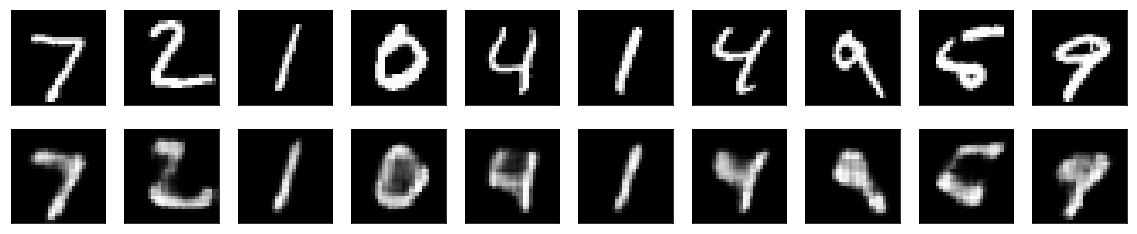

In [12]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[[[  0.00000000e+00   0.00000000e+00   8.71756268e+00   1.91928780e+00
     1.90417099e+00   0.00000000e+00   5.76481485e+00   0.00000000e+00]
  [  0.00000000e+00   3.53932285e+00   8.39964390e+00   6.05317926e+00
     0.00000000e+00   0.00000000e+00   1.37268019e+01   0.00000000e+00]
  [  4.55213130e-01   3.42062068e+00   6.77200699e+00   4.71708298e+00
     0.00000000e+00   0.00000000e+00   1.25002308e+01   0.00000000e+00]
  [  0.00000000e+00   3.96940064e+00   0.00000000e+00   2.31871200e+00
     0.00000000e+00   7.20063299e-02   6.17269945e+00   2.01860979e-01]]

 [[  2.58232212e+00   1.63336265e+00   1.30299063e+01   2.64779240e-01
     6.94269037e+00   0.00000000e+00   6.00515604e+00   0.00000000e+00]
  [  0.00000000e+00   1.90722871e+00   1.84182968e+01   9.37522793e+00
     1.40524750e+01   0.00000000e+00   1.52463951e+01   0.00000000e+00]
  [  0.00000000e+00   5.25665760e+00   1.89973793e+01   1.16585989e+01
     6.01207495e+00   0.00000000e+00   1.86460762e+01   4.38993454e+0

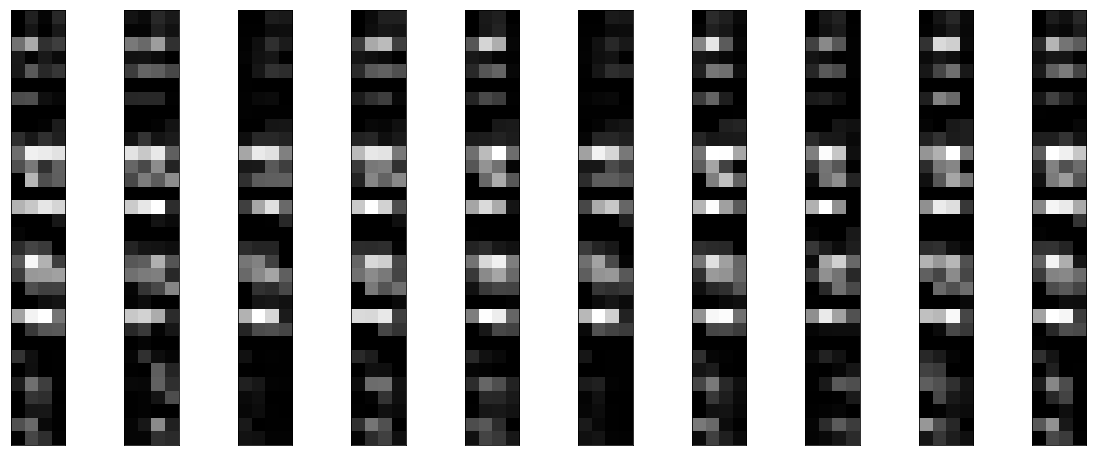

In [13]:
#We can also have a look at the 128-dimensional encoded representations. 
#These representations are 4x4x8, so we reshape them to 4x32 in order to be able to display them as grayscale images.

encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    
    if i == 0: 
        #print(encoded_imgs[i])
        #print(encoded_imgs[i].reshape(4, 4 * 8))
        #print(encoded_imgs[i].reshape(4, 4 * 8).T)
        
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
